In [27]:
# Importar bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Cargar los datos
df = pd.read_csv('healthcare_dataset_limpio.csv')
df.head()

,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Room Number,Admission Type,Medication,Test Results,Stay Duration,Categoria Edad,Discriminated,Doctor Code,Hospital Code,test_norm,med_norm,score_Triage,Triage
0,5,2,1,18856.281306,328,2,3,2,2,0,1,26320,29933,1.0,0.75,0.9,0
1,0,5,3,33643.327287,265,1,1,1,6,1,0,33355,16012,0.5,0.25,0.4,2
2,1,5,0,27955.096079,205,1,0,2,15,1,0,37534,5473,1.0,0.00,0.6,2
3,6,3,3,37909.782410,450,0,1,0,30,0,0,22226,12317,0.0,0.25,0.1,1
4,2,2,0,14238.317814,458,2,4,0,20,0,1,20973,33598,0.0,1.00,0.4,2


In [39]:
# Separar características (X) y variable objetivo (y)
X = df.drop(columns=['Discriminated','Doctor Code','Blood Type'])
y = df['Discriminated']

# Asegurar que la variable objetivo sea categórica
y = y.astype('int')  # Aseguramos que sea numérica entera para multiclase

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Entrenando modelo Random Forest...
Random Forest Accuracy: 0.9994542477715117
Reporte de clasificación (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5497
           1       1.00      1.00      1.00      5497

    accuracy                           1.00     10994
   macro avg       1.00      1.00      1.00     10994
weighted avg       1.00      1.00      1.00     10994



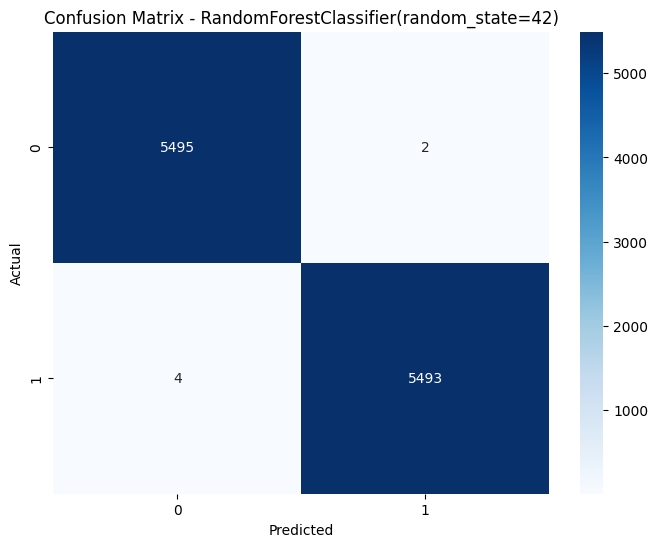

In [40]:
# Random Forest
print("Entrenando modelo Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Reporte de clasificación (Random Forest):\n", classification_report(y_test, rf_predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, rf_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {rf_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





In [41]:
# Evaluar el desempeño en el conjunto de entrenamiento
rf_train_predictions = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, rf_train_predictions)
test_accuracy = accuracy_score(y_test, rf_predictions)

# Mostrar las métricas de overfitting
print("\nEvaluación del modelo:")
print(f"Random Forest Accuracy (Train): {train_accuracy:.4f}")
print(f"Random Forest Accuracy (Test): {test_accuracy:.4f}")
print(f"Diferencia (Train - Test): {train_accuracy - test_accuracy:.4f}")


Evaluación del modelo:
Random Forest Accuracy (Train): 1.0000
Random Forest Accuracy (Test): 0.9995
Diferencia (Train - Test): 0.0005


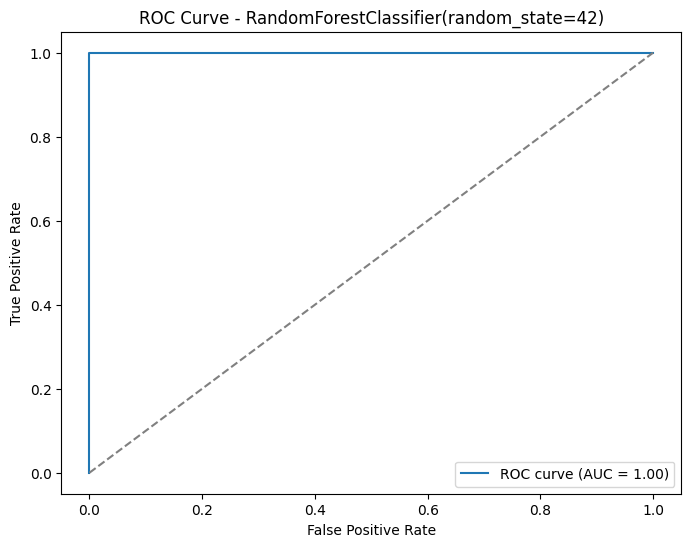

In [42]:
# Obtener las probabilidades de las predicciones
model_probabilities = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad para la clase positiva

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f"ROC Curve - {rf_model}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

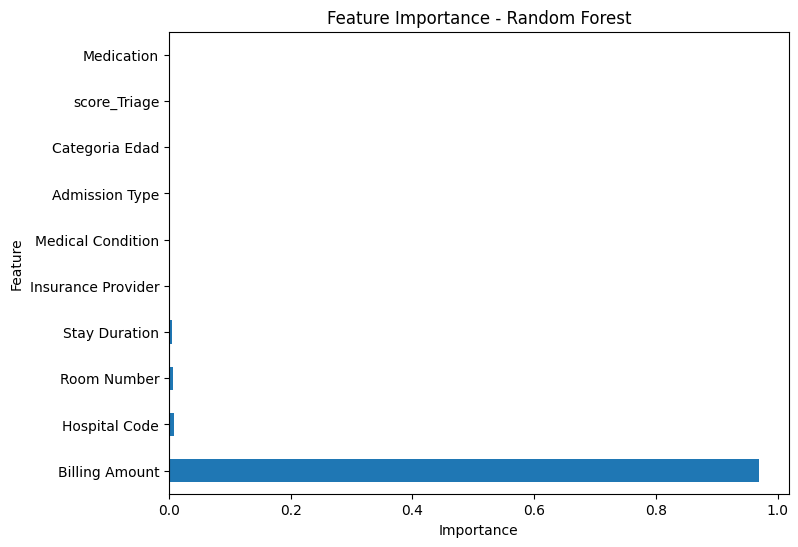

In [43]:
# Importancia de características
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

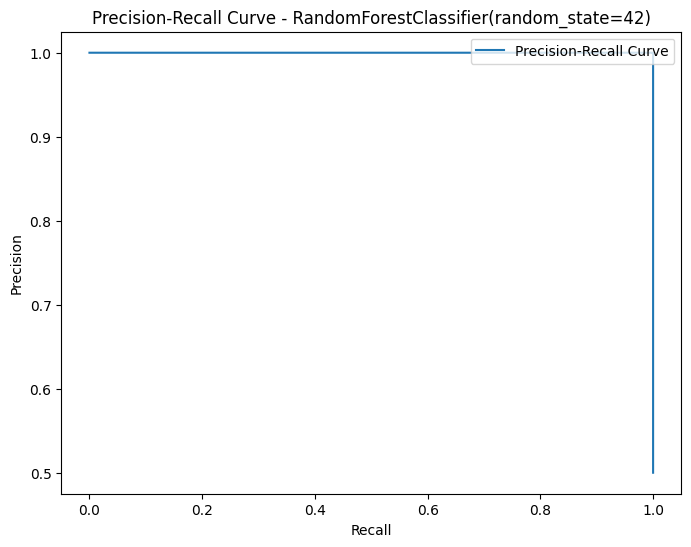

In [44]:
# Obtener probabilidades para la clase positiva
precision, recall, thresholds = precision_recall_curve(y_test, model_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title(f"Precision-Recall Curve - {rf_model}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.show()

In [45]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Scores de validación cruzada:", cv_scores)
print("Promedio de accuracy (validación cruzada):", cv_scores.mean())

Scores de validación cruzada: [0.99872658 0.9994542  0.99881743 0.99927226 0.99927226]
Promedio de accuracy (validación cruzada): 0.999108546773799


In [47]:
import joblib

joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']


Entrenando modelo XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:52:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9981808259050391
Reporte de clasificación (XGBoost):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5497
           1       1.00      1.00      1.00      5497

    accuracy                           1.00     10994
   macro avg       1.00      1.00      1.00     10994
weighted avg       1.00      1.00      1.00     10994



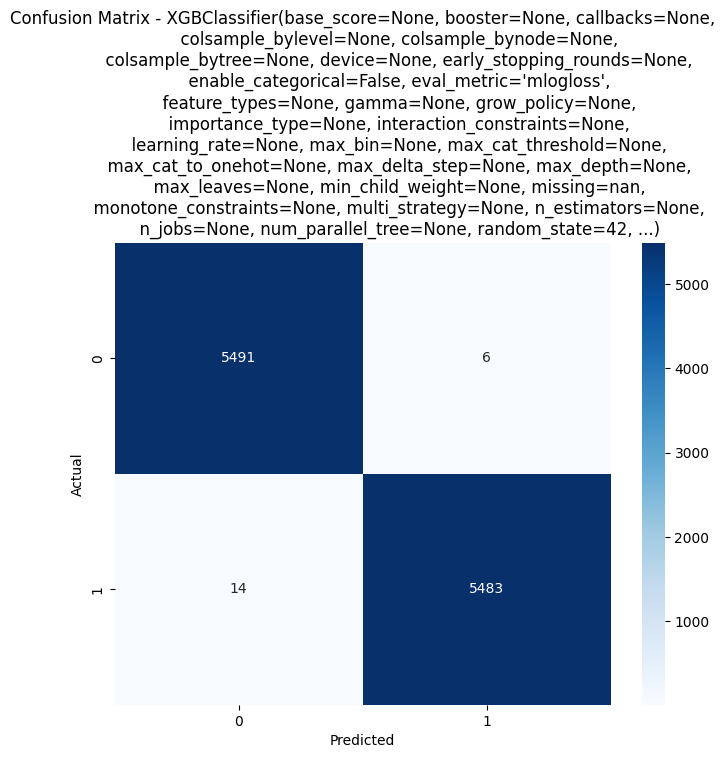

In [48]:
# XGBoost
print("\nEntrenando modelo XGBoost...")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("Reporte de clasificación (XGBoost):\n", classification_report(y_test, xgb_predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {xgb_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




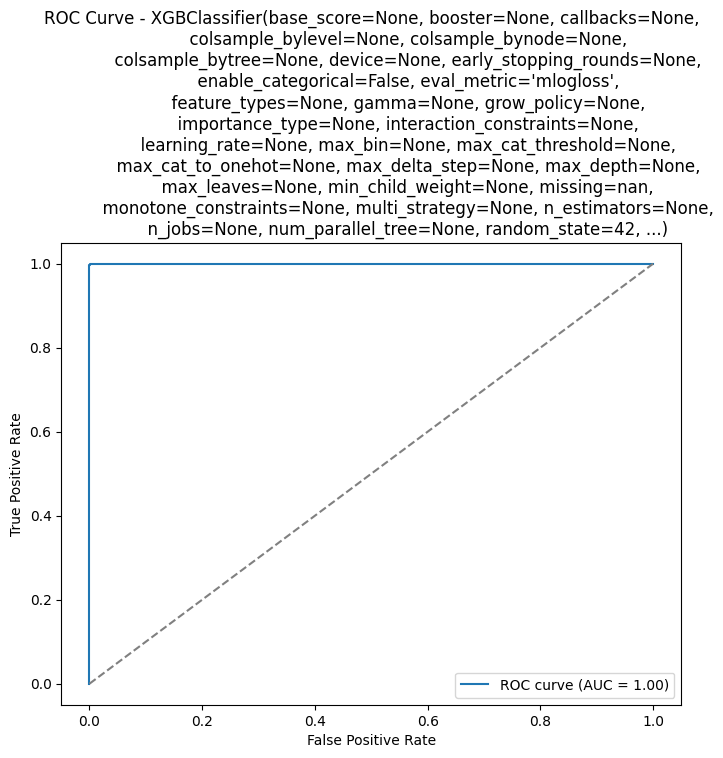

In [49]:
# Obtener las probabilidades de las predicciones
model_probabilities = xgb_model.predict_proba(X_test)[:, 1]  # Probabilidad para la clase positiva

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f"ROC Curve - {xgb_model}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [50]:
# Evaluar el desempeño en el conjunto de entrenamiento
xgb_train_predictions = xgb_model.predict(X_train)
train_accuracy = accuracy_score(y_train, xgb_train_predictions)
test_accuracy = accuracy_score(y_test, xgb_predictions)

# Mostrar las métricas de overfitting
print("\nEvaluación del modelo:")
print(f"XGBoost Accuracy (Train): {train_accuracy:.4f}")
print(f"XGBoost Accuracy (Test): {test_accuracy:.4f}")
print(f"Diferencia (Train - Test): {train_accuracy - test_accuracy:.4f}")


Evaluación del modelo:
XGBoost Accuracy (Train): 1.0000
XGBoost Accuracy (Test): 0.9982
Diferencia (Train - Test): 0.0018


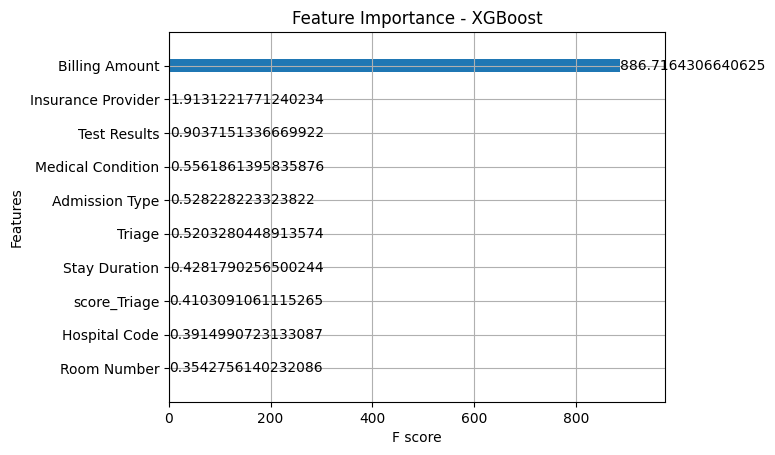

In [51]:
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain', height=0.4)
plt.title("Feature Importance - XGBoost")
plt.show()



Entrenando modelo LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21985, number of negative: 21987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 43972, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499977 -> initscore=-0.000091
[LightGBM] [Info] Start training from score -0.000091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

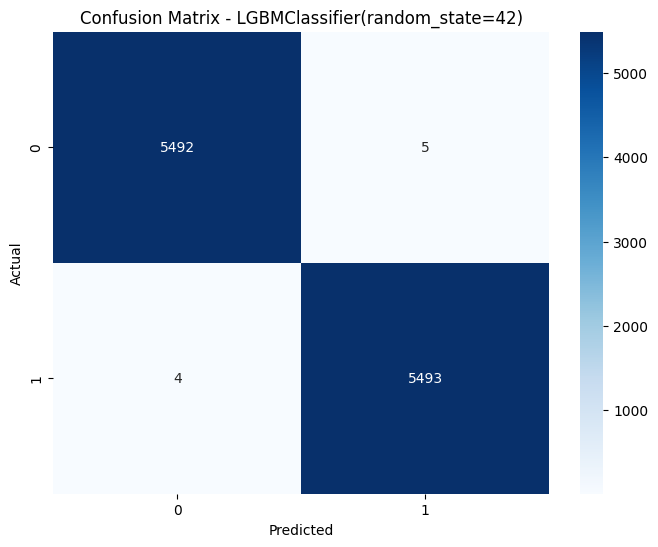

In [52]:
# LightGBM
print("\nEntrenando modelo LightGBM...")
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, lgb_predictions))
print("Reporte de clasificación (LightGBM):\n", classification_report(y_test, lgb_predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, lgb_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {lgb_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [53]:
# Evaluar el desempeño en el conjunto de entrenamiento
lgb_train_predictions = lgb_model.predict(X_train)
train_accuracy = accuracy_score(y_train, lgb_train_predictions)
test_accuracy = accuracy_score(y_test, lgb_predictions)

# Mostrar las métricas de overfitting
print("\nEvaluación del modelo:")
print(f"LightGBM Accuracy (Train): {train_accuracy:.4f}")
print(f"LightGBM Accuracy (Test): {test_accuracy:.4f}")
print(f"Diferencia (Train - Test): {train_accuracy - test_accuracy:.4f}")


Evaluación del modelo:
LightGBM Accuracy (Train): 1.0000
LightGBM Accuracy (Test): 0.9992
Diferencia (Train - Test): 0.0008


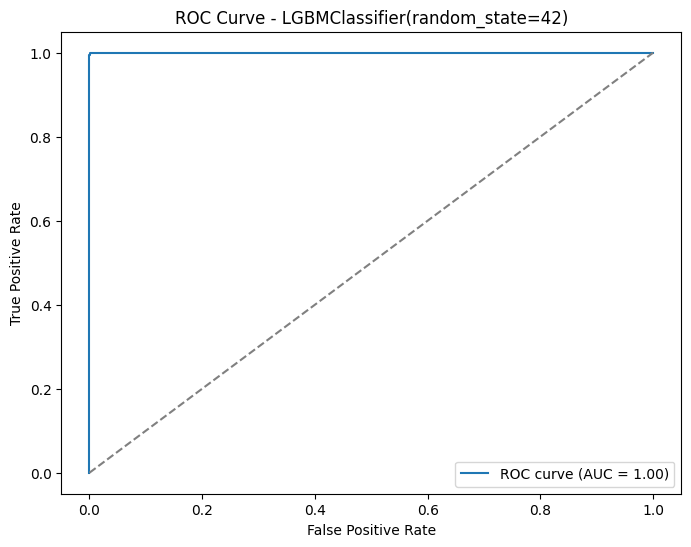

In [54]:
# Obtener las probabilidades de las predicciones
model_probabilities = lgb_model.predict_proba(X_test)[:, 1]  # Probabilidad para la clase positiva

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1],color='gray', linestyle='--')
plt.title(f"ROC Curve - {lgb_model}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

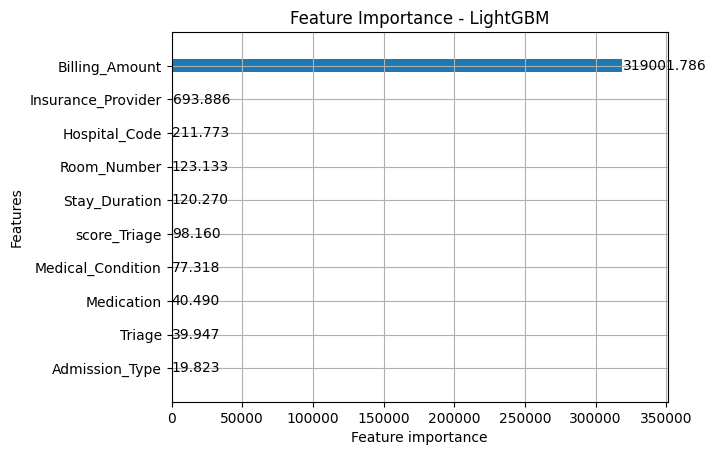

In [55]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='gain', height=0.4)
plt.title("Feature Importance - LightGBM")
plt.show()

In [56]:
# Verificar la distribución de la variable objetivo `Discriminated`
discriminated_distribution = df['Discriminated'].value_counts(normalize=True)

# Explorar correlaciones de las características con `Discriminated`
correlation_with_discriminated = df.corr()['Discriminated'].sort_values(ascending=False)

discriminated_distribution, correlation_with_discriminated

(Discriminated
 0    0.500018
 1    0.499982
 Name: proportion, dtype: float64,
 Discriminated         1.000000
 Stay Duration         0.005329
 score_Triage          0.004563
 Test Results          0.004137
 test_norm             0.004137
 Insurance Provider    0.004012
 Room Number           0.003559
 Medication            0.001957
 med_norm              0.001957
 Admission Type        0.001910
 Hospital Code         0.001349
 Blood Type            0.000930
 Categoria Edad        0.000342
 Doctor Code          -0.004359
 Triage               -0.005841
 Medical Condition    -0.006113
 Billing Amount       -0.865379
 Name: Discriminated, dtype: float64)